# Data Cleaning

**This Notebook implements the First ARIMA Model using only the IG Spread**

In [1]:
import pandas as pd
import warnings

df = pd.read_csv("Cleaned_WITHOUT_COVID.csv")

warnings.filterwarnings('ignore')

df = df[['Date', 'CDX IG Spread']]

In [2]:
df['Date'] = pd.to_datetime(df['Date'])

df_date_index = df.set_index('Date')

# Data Viz

*Break down plots into Month / Year / Full Dataset*

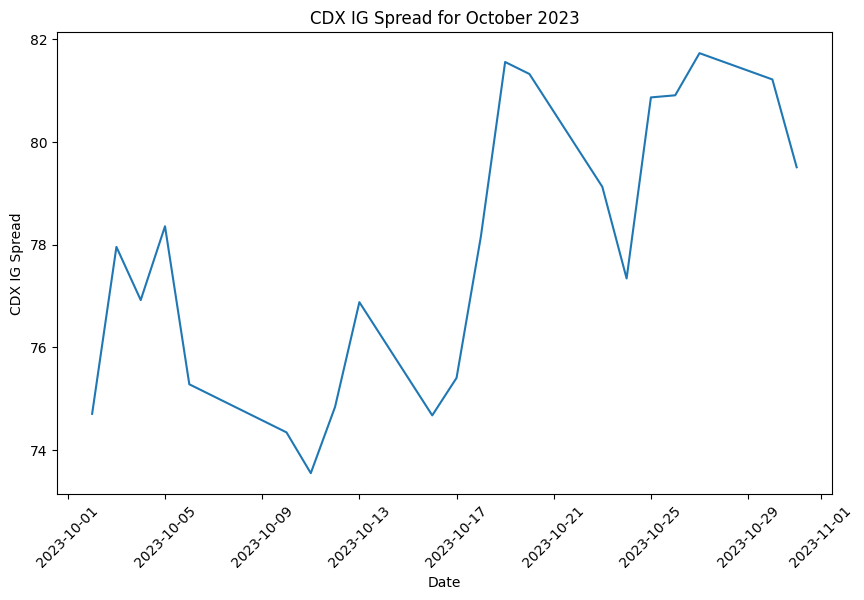

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df_oct_2023 = df[df['Date'].dt.to_period('M') == '2023-10']
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='CDX IG Spread', data=df_oct_2023)
plt.title('CDX IG Spread for October 2023')
plt.xticks(rotation=45)
plt.show()

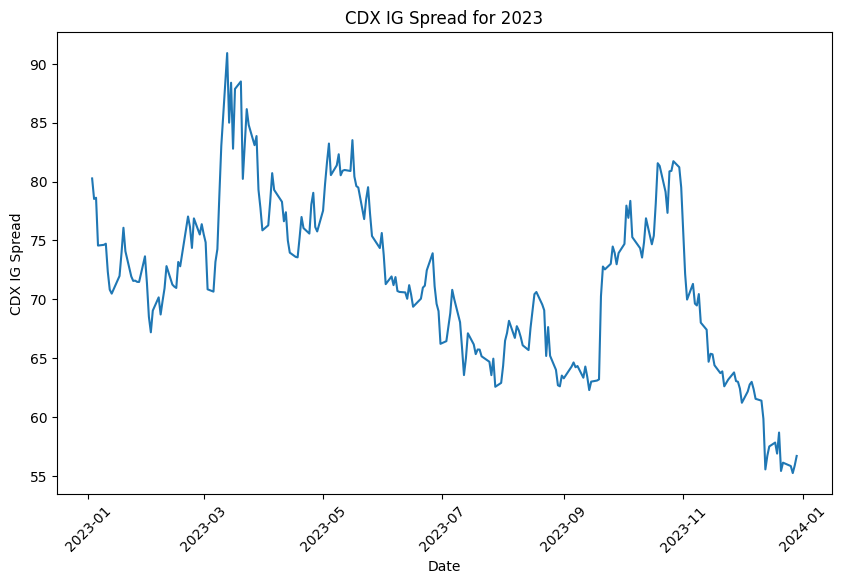

In [4]:
df_2023 = df[df['Date'].dt.to_period('Y') == '2023']
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='CDX IG Spread', data=df_2023)
plt.title('CDX IG Spread for 2023')
plt.xticks(rotation=45)
plt.show()

*There are peaks around March and October. Let's plot a few more years to see if this seasonality exists in other years.*

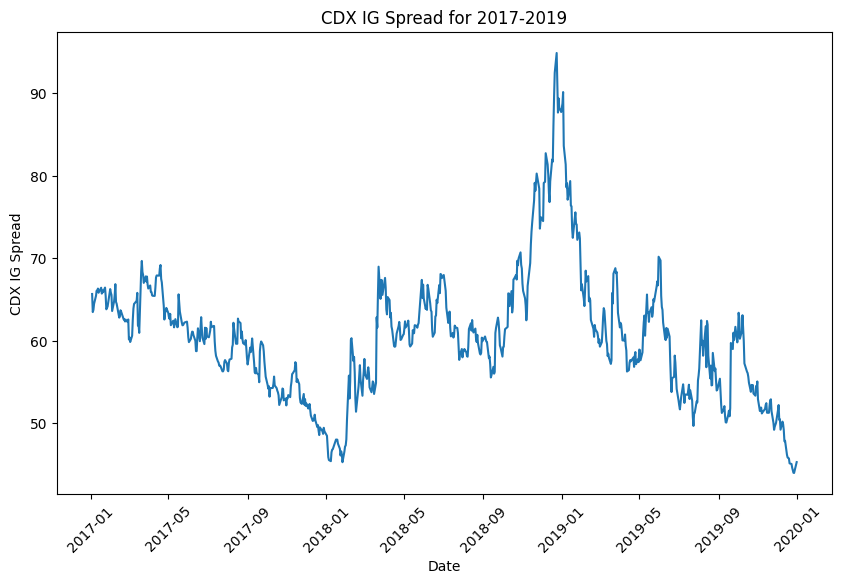

In [5]:
df_2017_2019 = df[(df['Date'].dt.year >= 2017) & (df['Date'].dt.year <= 2019)]
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='CDX IG Spread', data=df_2017_2019)
plt.title('CDX IG Spread for 2017-2019')
plt.xticks(rotation=45)
plt.show()

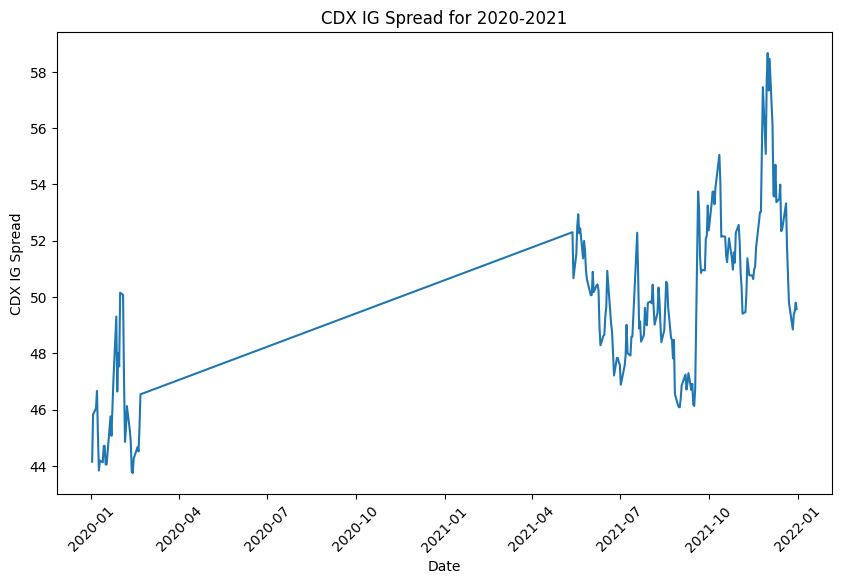

In [6]:
df_2017_2019 = df[(df['Date'].dt.year >= 2020) & (df['Date'].dt.year <= 2021)]
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='CDX IG Spread', data=df_2017_2019)
plt.title('CDX IG Spread for 2020-2021')
plt.xticks(rotation=45)
plt.show()

*There is no obvious consistent seasonality each year*

# Finding Parameters 

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = df[(df['Date'] <= '2020-02-24') | (df['Date'] > '2021-05-12')].reset_index()

# Step 1: Check for stationarity and determine 'd'
result = adfuller(df['CDX IG Spread'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.252609
p-value: 0.017134


Our p-value = 0.017 < 0.05 implies a stationary CDX NA IG Time Series. \
Differencing is not required, so d = 0 in our model.

Text(0, 0.5, 'Autocorrelation')

<Figure size 2000x1000 with 0 Axes>

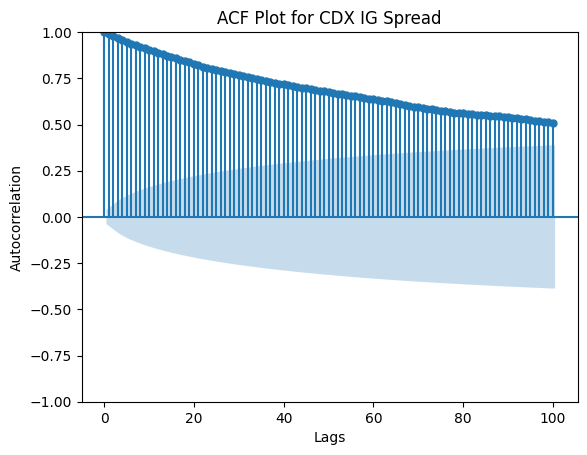

In [8]:
# Step 2: Identify 'p' and 'q' using ACF and PACF 
plt.figure(figsize=(20, 10)) 
plot_acf(df['CDX IG Spread'], lags=100, alpha=0.05)

plt.title('ACF Plot for CDX IG Spread')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

1. There's a strong positive autocorrelation at the initial lags that gradually decreases as the number of lags increases. 
2. Remaining above the confidence interval for many lags implies that the CDX IG Spread values are positively correlated with their previous values for a considerable number of periods. (i.e. using  an arbitary point from May to predict a point in August would receive fair results) 
3. Because it is over many lags, this implies that the time series has a long memory, meaning past values have a lasting effect on future values. 
4. Because of this fact, a Moving Average model (the MA component of ARIMA) is not necessary to start, q = 0.

Text(0, 0.5, 'Autocorrelation')

<Figure size 2000x1000 with 0 Axes>

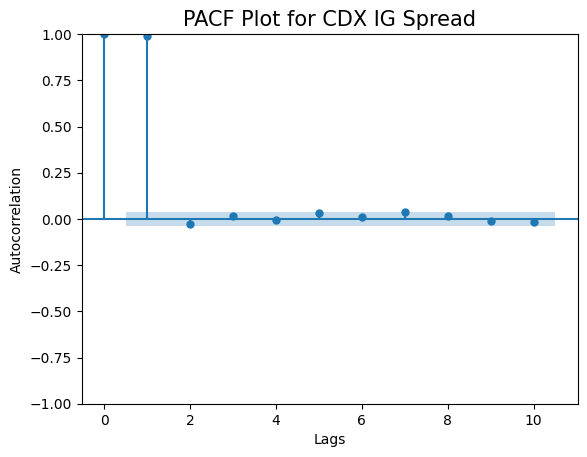

In [9]:
plt.figure(figsize=(20, 10))  
plot_pacf(df['CDX IG Spread'], lags=10, alpha=0.05)

plt.title('PACF Plot for CDX IG Spread', fontsize=15)

plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

1. The very first bar at lag 0 is always 1 because the series is perfectly correlated with itself at lag 0.

2. The significant spike at lag 1 indicates that there is a strong correlation between each observation and the one immediately preceding it, even after accounting for the correlations at all shorter lags.

3. After lag 1, the partial autocorrelation coefficients are all within the confidence interval band around zero, suggesting that they are not significantly different from zero.

4. From this PACF plot, one might infer that an AR(1) model could be appropriate for this time series, as only the first lag is significantly different from zero. This means that the current value of the series is largely dependent on its immediate previous value, with the effect of further past values being negligible when the immediate past is accounted for.

# AR(1) with rolling training of ground truths

In [10]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

train_size = int(len(df_date_index) * 0.8) 

train, test = df_date_index['CDX IG Spread'].sort_index().iloc[:train_size], df_date_index['CDX IG Spread'].sort_index().iloc[train_size:]

history = train.tolist()
predictions = []

# Rolling forecasts
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t]) 

# Evaluate performance
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 2.358


AttributeError: 'ARIMA' object has no attribute 'summary'

In [17]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2570
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -5334.205
Date:                Wed, 27 Mar 2024   AIC                          10674.410
Time:                        14:53:26   BIC                          10691.965
Sample:                             0   HQIC                         10680.774
                               - 2570                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.1407      4.839     14.495      0.000      60.657      79.625
ar.L1          0.9917      0.003    390.972      0.000       0.987       0.997
sigma2         3.7123      0.063     58.534      0.000       3.588       3.837
===================================================================================
Ljung-Box (L1) (Q):                   1.84   Jarque-Bera (JB):              1663.32
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.51
Prob(H) (two-sided):                  0.28   Kurtosis:                         6.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

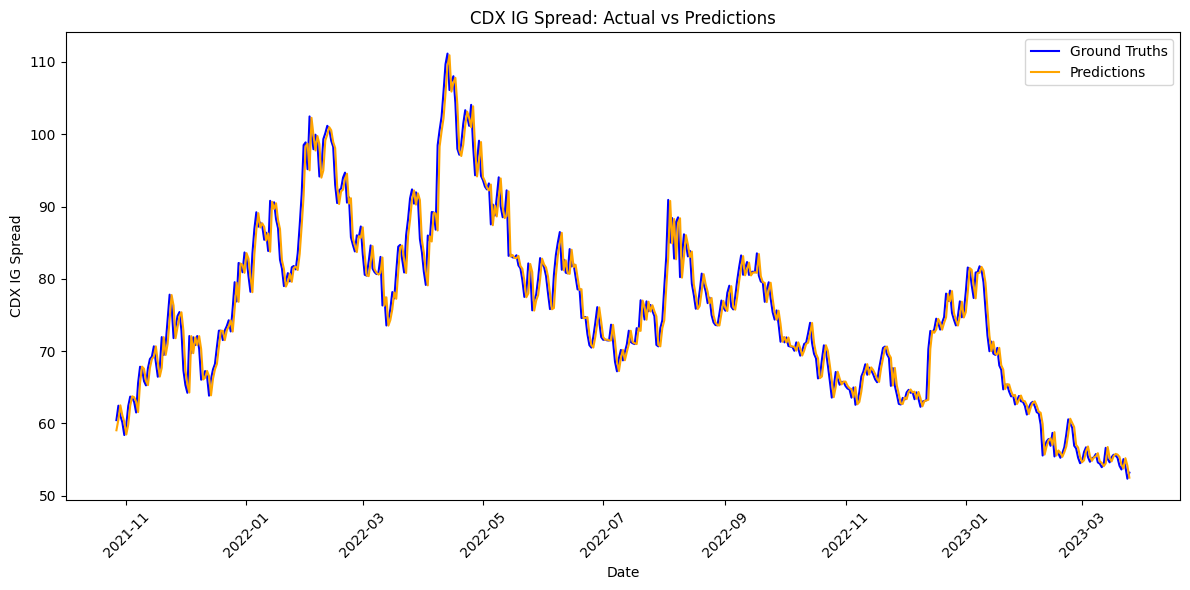

In [ ]:
dates = pd.date_range(start='2021-10-27', periods=len(test), freq='D')

plt.figure(figsize=(12, 6))
plt.plot(dates, test, label='Ground Truths', color='blue')
plt.plot(dates, predictions, label='Predictions', color='orange')

plt.title('CDX IG Spread: Actual vs Predictions')
plt.xlabel('Date')
plt.ylabel('CDX IG Spread')
plt.legend()
plt.xticks(rotation=45)  
plt.tight_layout()  

It looks like there could be a 1-day lag when forecasting. This is indicative of a model close to a random walk. Let's investigate with a smaller time subset.

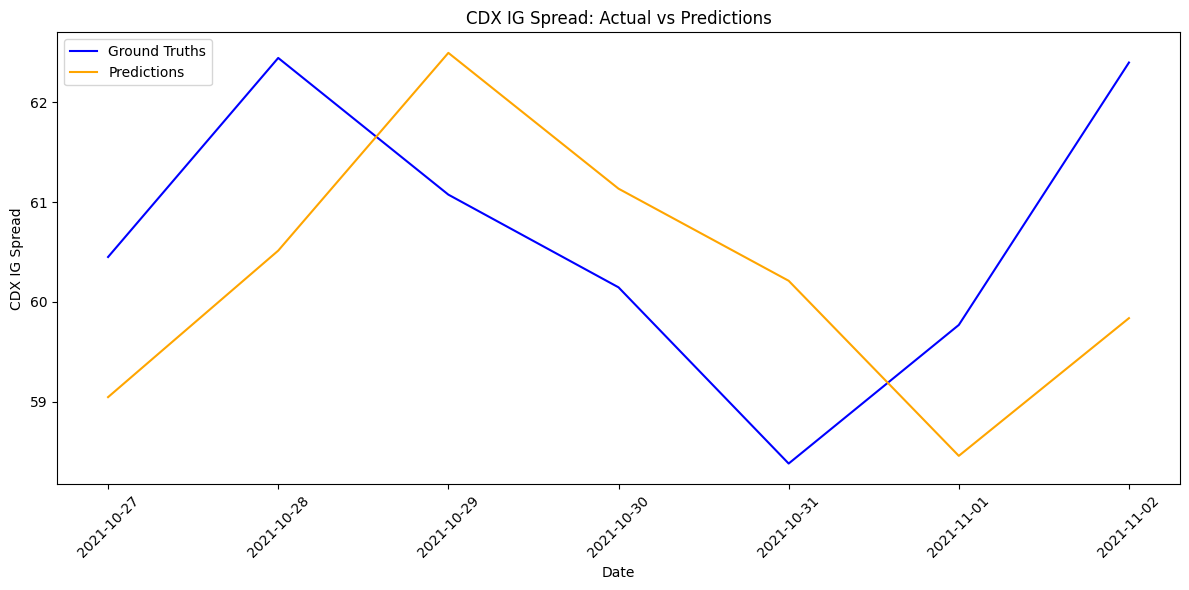

In [ ]:
dates = pd.date_range(start='2021-10-27', periods=7, freq='D')

plt.figure(figsize=(12, 6))
plt.plot(dates, test[:7], label='Ground Truths', color='blue')
plt.plot(dates, predictions[:7], label='Predictions', color='orange')

plt.title('CDX IG Spread: Actual vs Predictions')
plt.xlabel('Date')
plt.ylabel('CDX IG Spread')
plt.legend()
plt.xticks(rotation=45)  
plt.tight_layout()  

That is exactly what is happening. It appears we are forecasting one day ahead of the actual sample when the model is behaving the way we expect it where the prediction is the sum of the previous sample and a small correction term. 

# AR(1) with rolling retraining on Predictions

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


history = train.tolist()
predictions = []

# Rolling forecasts
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(predictions[-1]) 

# Evaluate performance
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


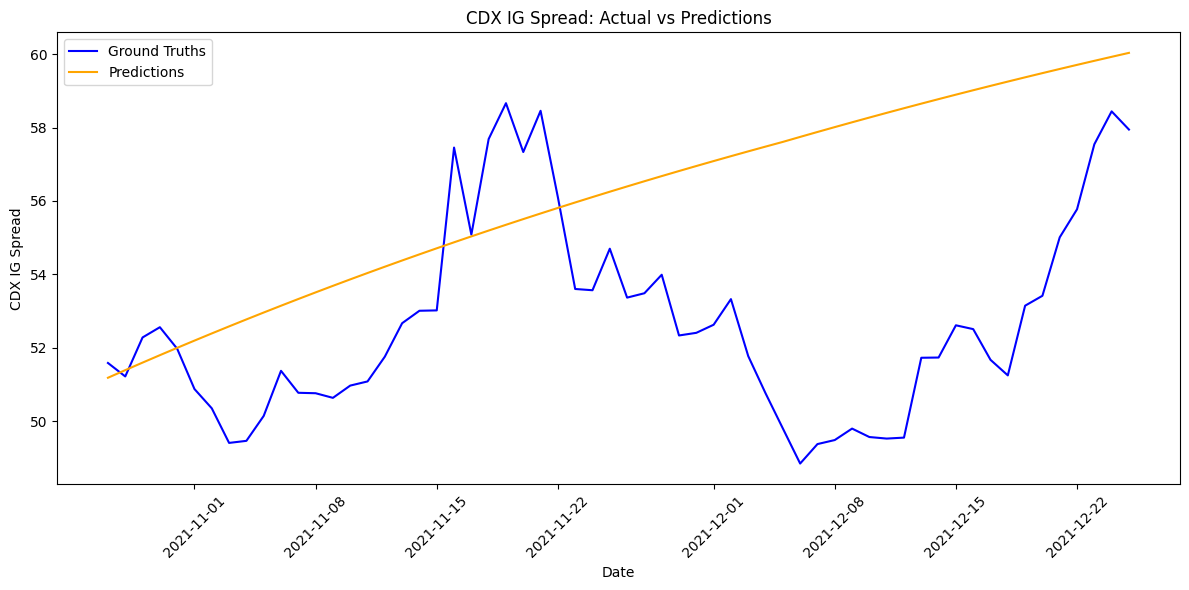

In [ ]:
dates = pd.date_range(start='2021-10-27', periods=60, freq='D')

plt.figure(figsize=(12, 6))
plt.plot(dates, test[:60], label='Ground Truths', color='blue')
plt.plot(dates, predictions[:60], label='Predictions', color='orange')

plt.title('CDX IG Spread: Actual vs Predictions')
plt.xlabel('Date')
plt.ylabel('CDX IG Spread')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

train_size = int(len(df_date_index) * 0.8)
train = df_date_index['CDX IG Spread'].sort_index().iloc[:train_size]
test = df_date_index['CDX IG Spread'].sort_index().iloc[train_size:]

history = train.tolist()

predictions = []


start_point = 0

while start_point + 21 <= len(test):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=21)
    
    predictions.append(forecast[-1]) 
    

    history.append(predictions[-1])
    
    start_point += 21

aligned_test = test.iloc[21-1::21]

rmse = sqrt(mean_squared_error(aligned_test, predictions))
print(f'Test RMSE: {rmse:.3f}')


Test RMSE: 13.555


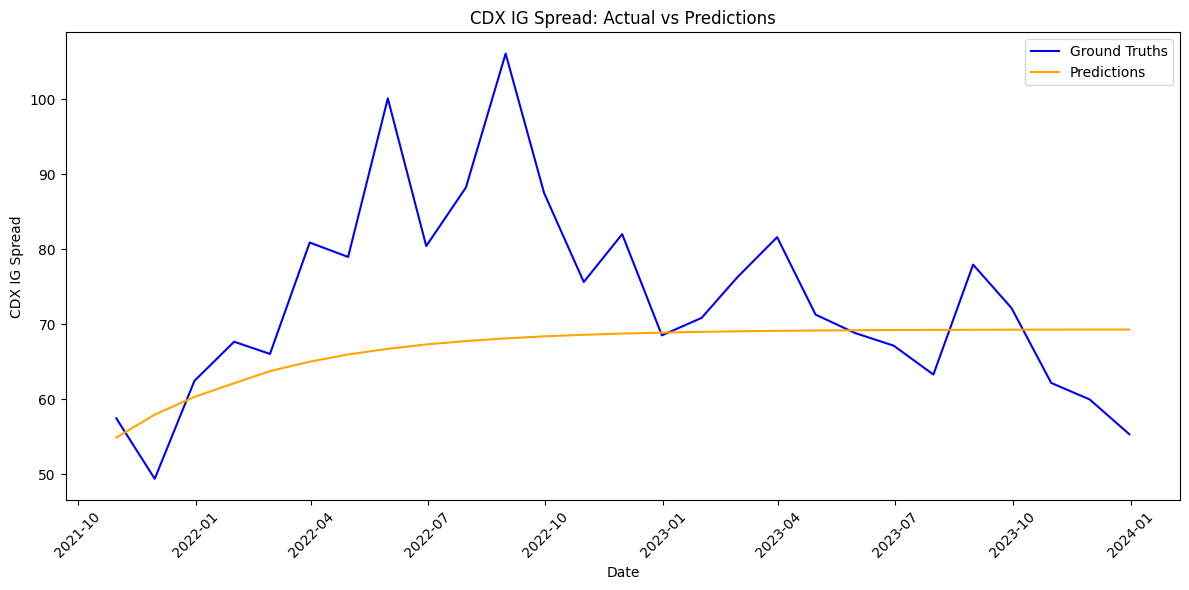

In [ ]:
dates = pd.date_range(start='2021-10-27', periods=27, freq='M')

plt.figure(figsize=(12, 6))
plt.plot(dates, aligned_test, label='Ground Truths', color='blue')
plt.plot(dates, predictions, label='Predictions', color='orange')

plt.title('CDX IG Spread: Actual vs Predictions')
plt.xlabel('Date')
plt.ylabel('CDX IG Spread')
plt.legend()
plt.xticks(rotation=45)  
plt.tight_layout()  